In [7]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [8]:
window_sizes = [1,3,5,7,11,13,17,19] # but in seconds
print(window_sizes)
z_score_threshold = 3

[1, 3, 5, 7, 11, 13, 17, 19]


In [9]:
# df = pd.read_csv("data/finnhub7-12-2h.csv")
df = pd.read_csv("data/finnhub_anomalies.csv")
columns = ["price", "volume", "trade_ts"]
timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"
df = df[columns]
df["trade_ts"] = df["trade_ts"].apply(lambda a: datetime.strptime(a, timestamp_format))
df = df.set_index("trade_ts")
# df.index = pd.to_datetime(df.index)

In [10]:
print(df.describe())
print(df.info())
df.head()

               price        volume
count   41004.000000  41004.000000
mean    99593.300784      0.150706
std     11323.244802      1.327159
min        31.299671     -6.573366
25%    101328.640000      0.000230
50%    101592.510000      0.000880
75%    101768.350000      0.007060
max    102732.810421     13.181165
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41004 entries, 2024-12-06 20:15:19.022000+00:00 to 2024-12-06 21:10:14.289000+00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   41004 non-null  float64
 1   volume  41004 non-null  float64
dtypes: float64(2)
memory usage: 961.0 KB
None


,price,volume
trade_ts,,
2024-12-06 20:15:19.022000+00:00,101655.99,0.00020
2024-12-06 20:15:19.454000+00:00,101655.99,0.00494
2024-12-06 20:15:19.501000+00:00,101655.99,0.00245
2024-12-06 20:15:19.919000+00:00,101660.85,0.01967
2024-12-06 20:15:19.921000+00:00,101662.23,0.00006


In [11]:
df['volume_smooth'] = df['volume'].rolling(window=window_sizes[0]).mean()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['volume_normalized'] = scaler.fit_transform(df[['volume']])
df['volume_diff'] = df['volume'] - df['volume'].shift(1)
df['volume_pct_change'] = df['volume'].pct_change()


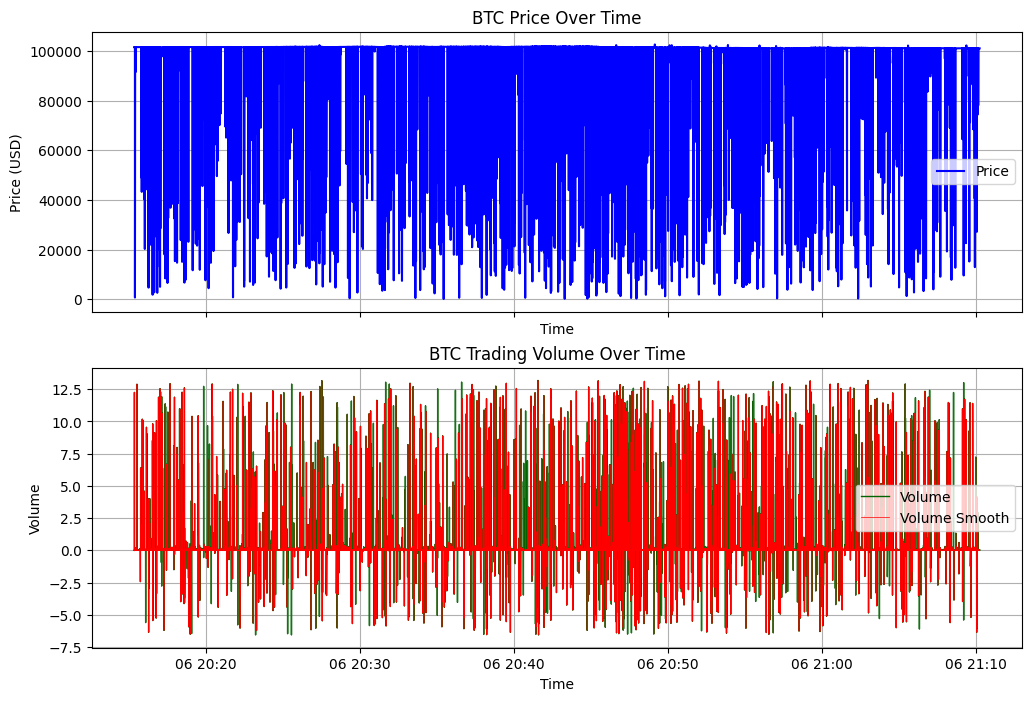

In [12]:
# Plot Price and Volume
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Price
ax[0].plot(df.index, df["price"], label="Price", color="blue", linewidth=1.5)
ax[0].set_title("BTC Price Over Time")
ax[0].set_ylabel("Price (USD)")
ax[0].set_xlabel("Time")
ax[0].grid(True)
ax[0].legend()

# Plot Volume
ax[1].plot(df.index, df["volume"], label="Volume", color="darkgreen", linewidth=1)
ax[1].plot(df.index, df["volume_smooth"], label="Volume Smooth", color="red", linewidth=0.5)
ax[1].set_title("BTC Trading Volume Over Time")
ax[1].set_ylabel("Volume")
ax[1].set_xlabel("Time")
ax[1].grid(True)
ax[1].legend()

# Adjust layout and show the plots
# plt.tight_layout()
plt.show()



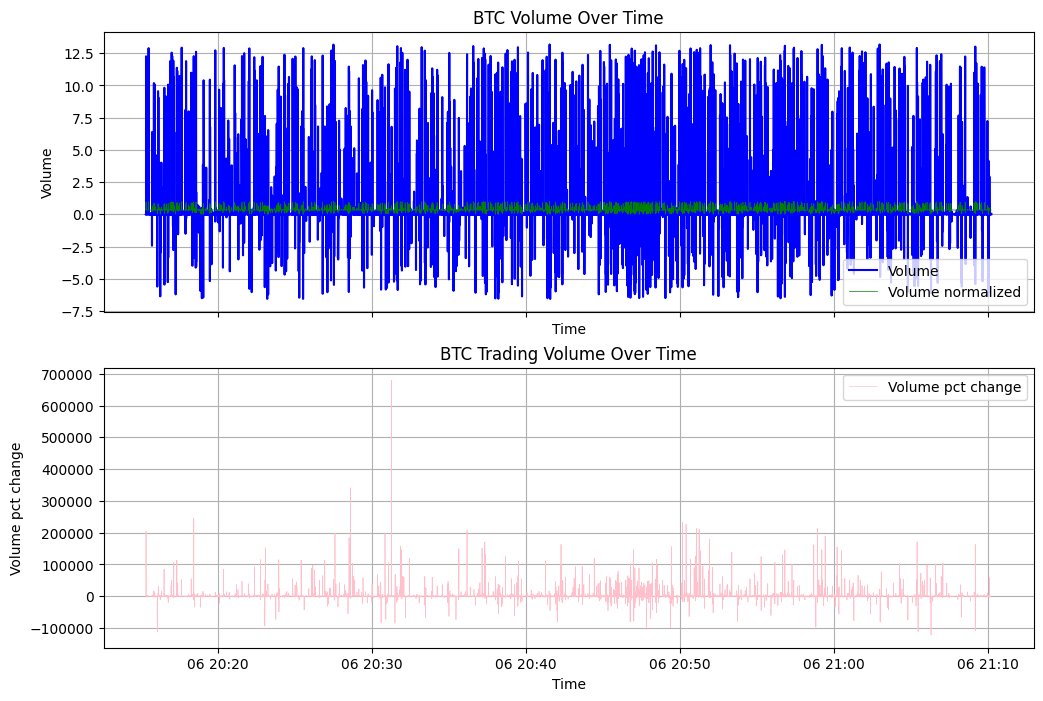

In [13]:
# Plot Price and Volume
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Price
ax[0].plot(df.index, df["volume"], label="Volume", color="blue", linewidth=1.5)
ax[0].plot(df.index, df["volume_normalized"], label="Volume normalized", color="green", linewidth=0.5)
ax[0].set_title("BTC Volume Over Time")
ax[0].set_ylabel("Volume")
ax[0].set_xlabel("Time")
ax[0].grid(True)
ax[0].legend()

# Plot Volume
# ax[1].plot(df.index, df["volume"], label="Volume", color="orange", linewidth=1)
ax[1].plot(df.index, df["volume_pct_change"], label="Volume pct change", color="pink", linewidth=0.5)
ax[1].set_title("BTC Trading Volume Over Time")
ax[1].set_ylabel("Volume pct change")
ax[1].set_xlabel("Time")
ax[1].grid(True)
ax[1].legend()

# Adjust layout and show the plots
# plt.tight_layout()
plt.show()

In [14]:
def detect_anomalies_sliding_window(dataframe, column, window_size_seconds, threshold):
    """
    Detect anomalies using z-scores, applying a sliding window where the rolling window is based on seconds.
    
    :param dataframe: Input DataFrame with a time-based index
    :param column: Column name to analyze
    :param window_size_seconds: Sliding window size in seconds
    :param threshold: Z-score threshold for anomaly detection
    :return: Boolean Series indicating anomalies
    """
    # Convert window size in seconds to appropriate rolling window
    window = f"{window_size_seconds}s"
    
    # Apply rolling method with sliding window
    rolling_mean = dataframe[column].rolling(window=window, min_periods=1, closed='both').mean()
    rolling_std = dataframe[column].rolling(window=window, min_periods=1, closed='both').std()
    
    # Calculate z-scores
    z_scores = (dataframe[column] - rolling_mean) / rolling_std
    
    # Identify anomalies
    anomalies = np.abs(z_scores) > threshold
    return anomalies

{'price': np.int64(1034), 'volume': np.int64(918)}
{'price': np.int64(1591), 'volume': np.int64(1369)}
{'price': np.int64(1478), 'volume': np.int64(1186)}
{'price': np.int64(1330), 'volume': np.int64(1110)}
{'price': np.int64(1142), 'volume': np.int64(1030)}
{'price': np.int64(1121), 'volume': np.int64(1011)}
{'price': np.int64(1061), 'volume': np.int64(1007)}
{'price': np.int64(1048), 'volume': np.int64(1004)}


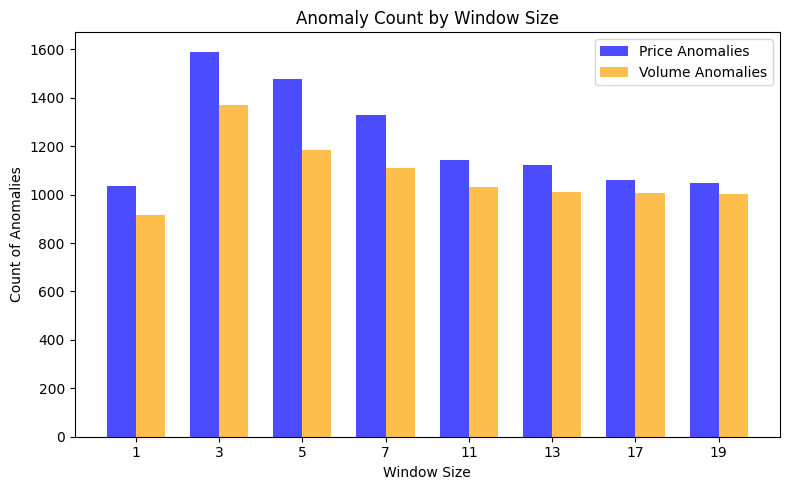

In [15]:
# Apply anomaly detection for each window size
anomalies_summary = {}

for window in window_sizes:
    anomalies_price = detect_anomalies_sliding_window(df, 'price', window, z_score_threshold)
    anomalies_volume = detect_anomalies_sliding_window(df, 'volume', window, z_score_threshold)
    
    # Count anomalies
    anomalies_count = {
        'price': anomalies_price.sum(),
        'volume': anomalies_volume.sum()
    }
    anomalies_summary[window] = anomalies_count
    print(anomalies_count)

# Extract data for plotting
window_sizes = list(anomalies_summary.keys())
price_anomalies = [anomalies_summary[window]['price'] for window in window_sizes]
volume_anomalies = [anomalies_summary[window]['volume'] for window in window_sizes]

# Set up the bar chart
x = np.arange(len(window_sizes))  # x positions for groups
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(8, 5))

# Plot price anomalies
ax.bar(x - width/2, price_anomalies, width, label='Price Anomalies', color='blue', alpha=0.7)

# Plot volume anomalies
ax.bar(x + width/2, volume_anomalies, width, label='Volume Anomalies', color='orange', alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel('Window Size')
ax.set_ylabel('Count of Anomalies')
ax.set_title('Anomaly Count by Window Size')
ax.set_xticks(x)
ax.set_xticklabels(window_sizes)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()

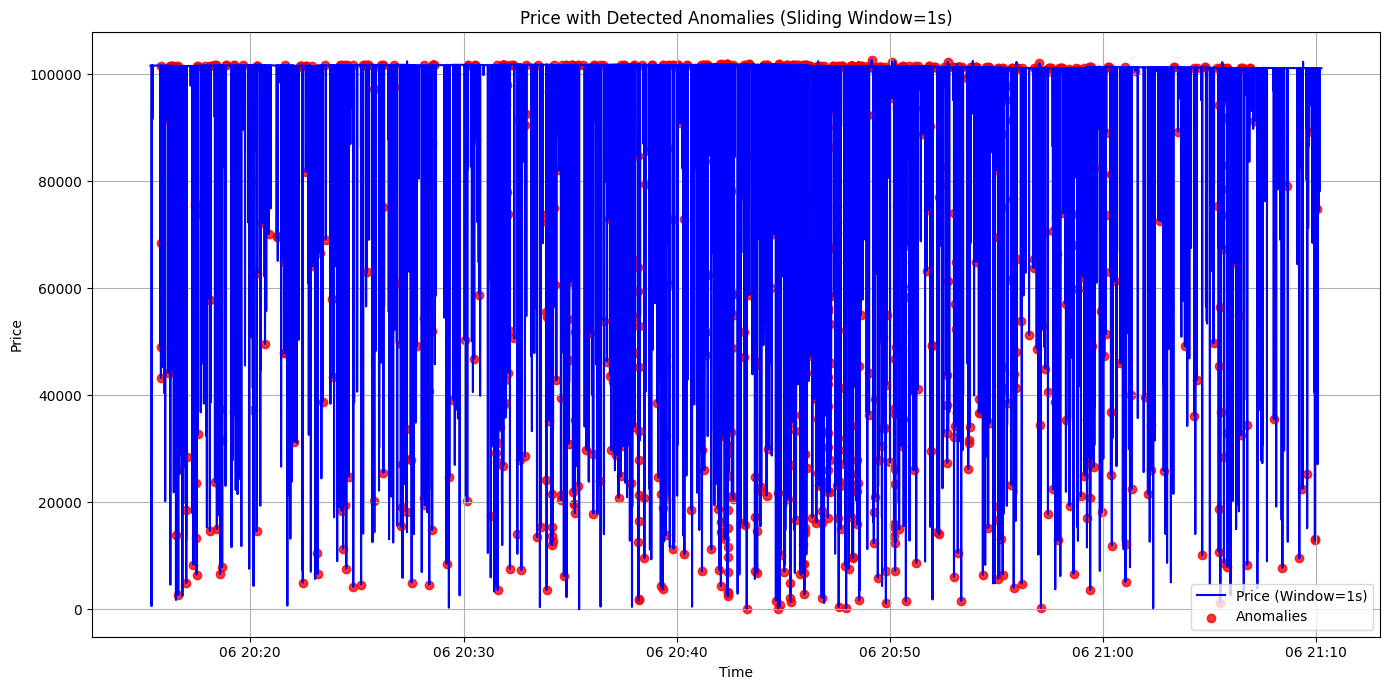

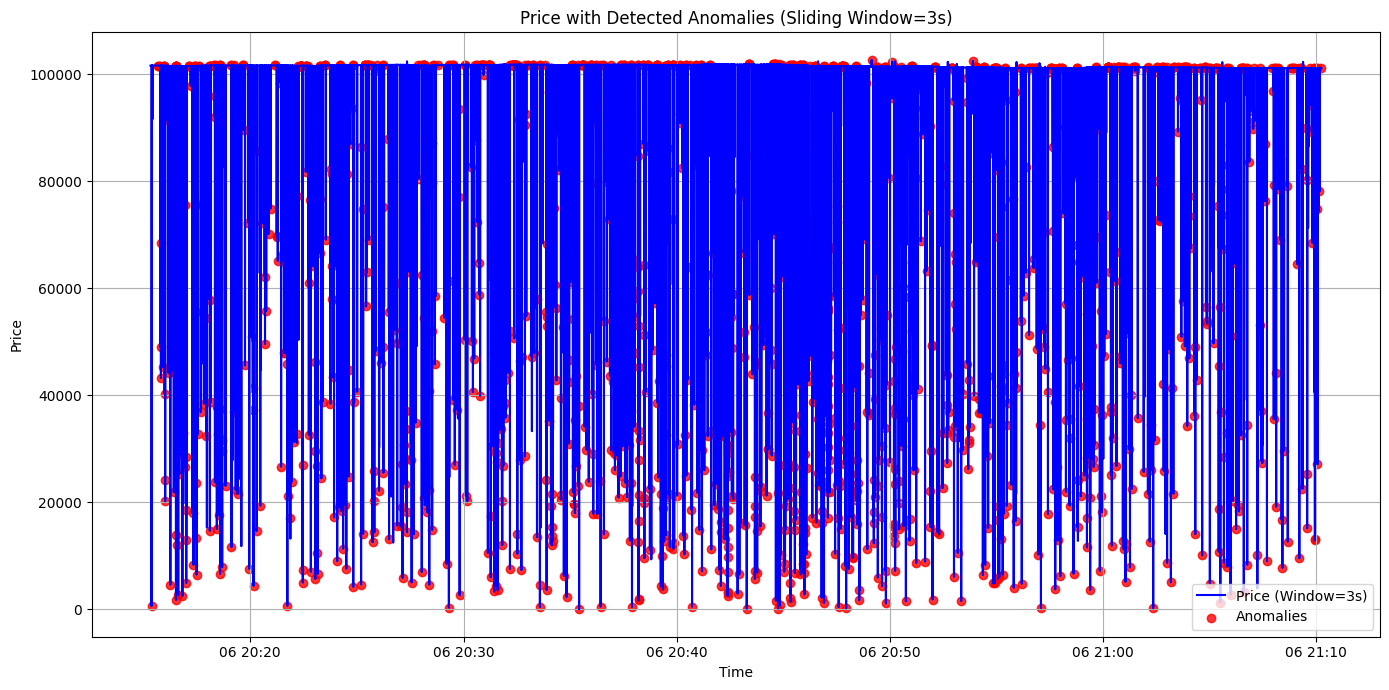

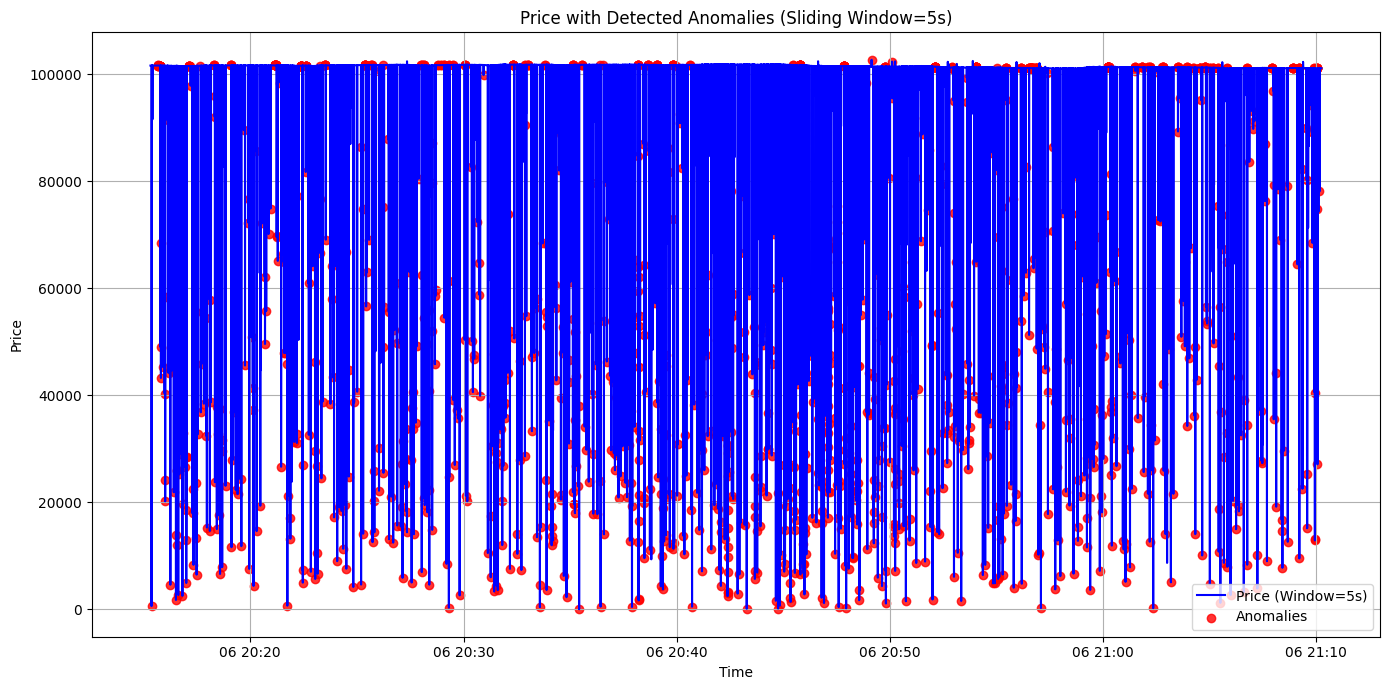

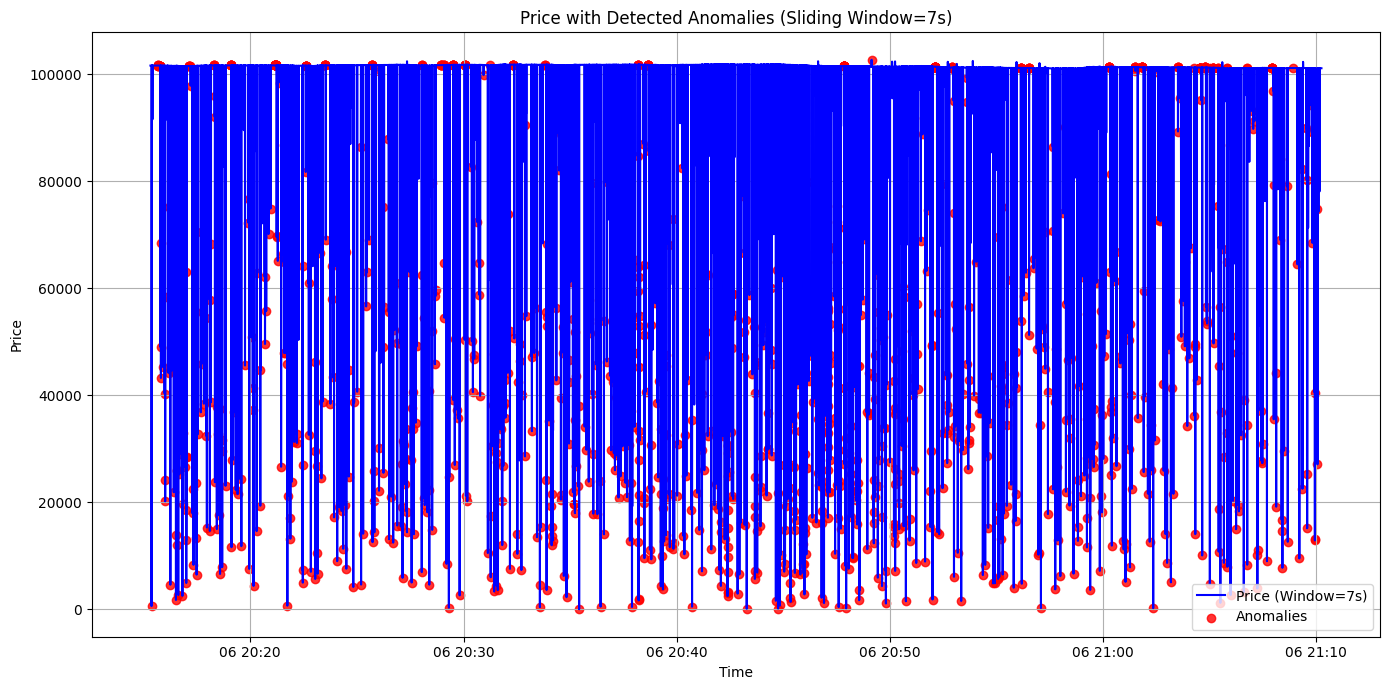

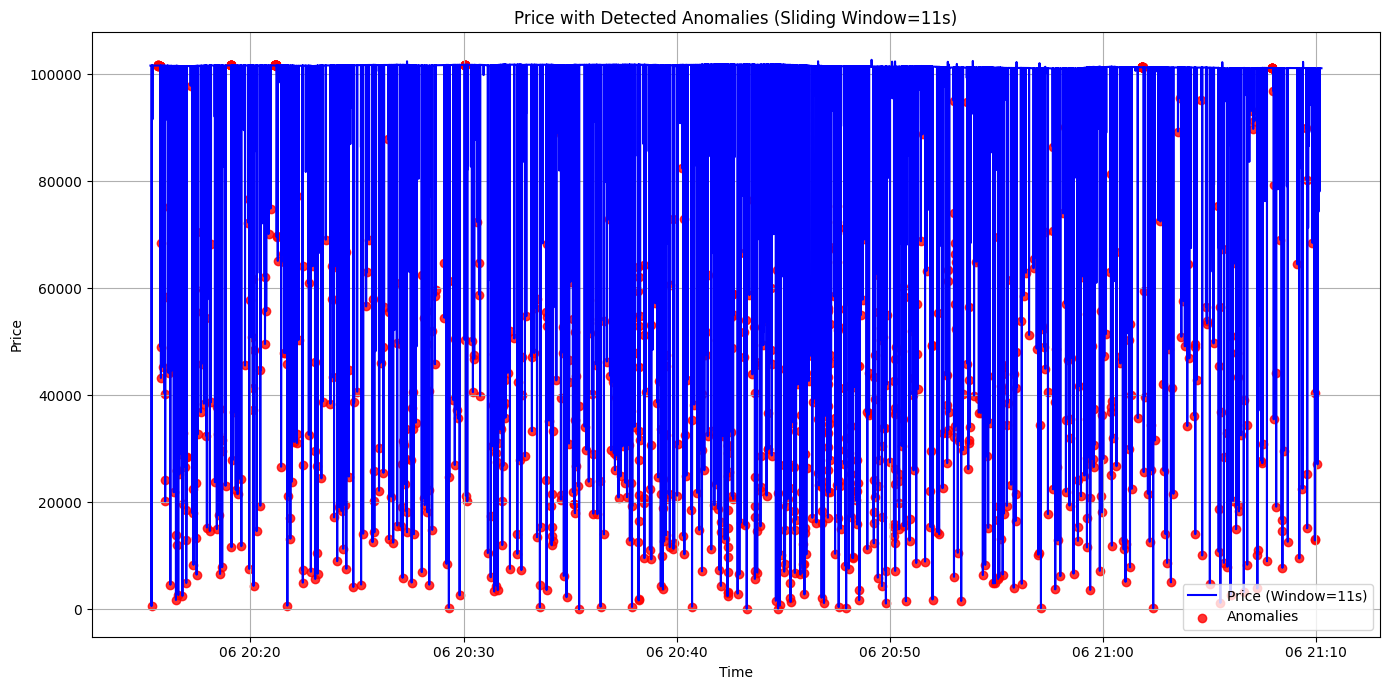

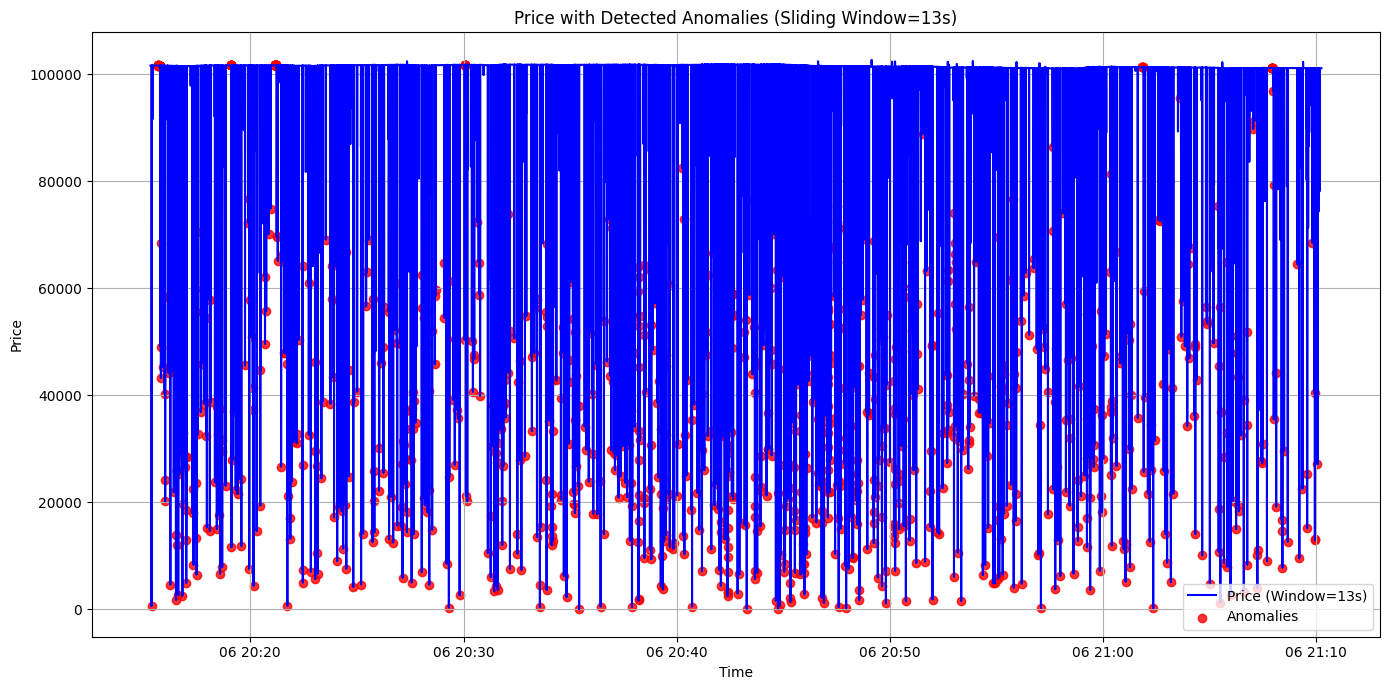

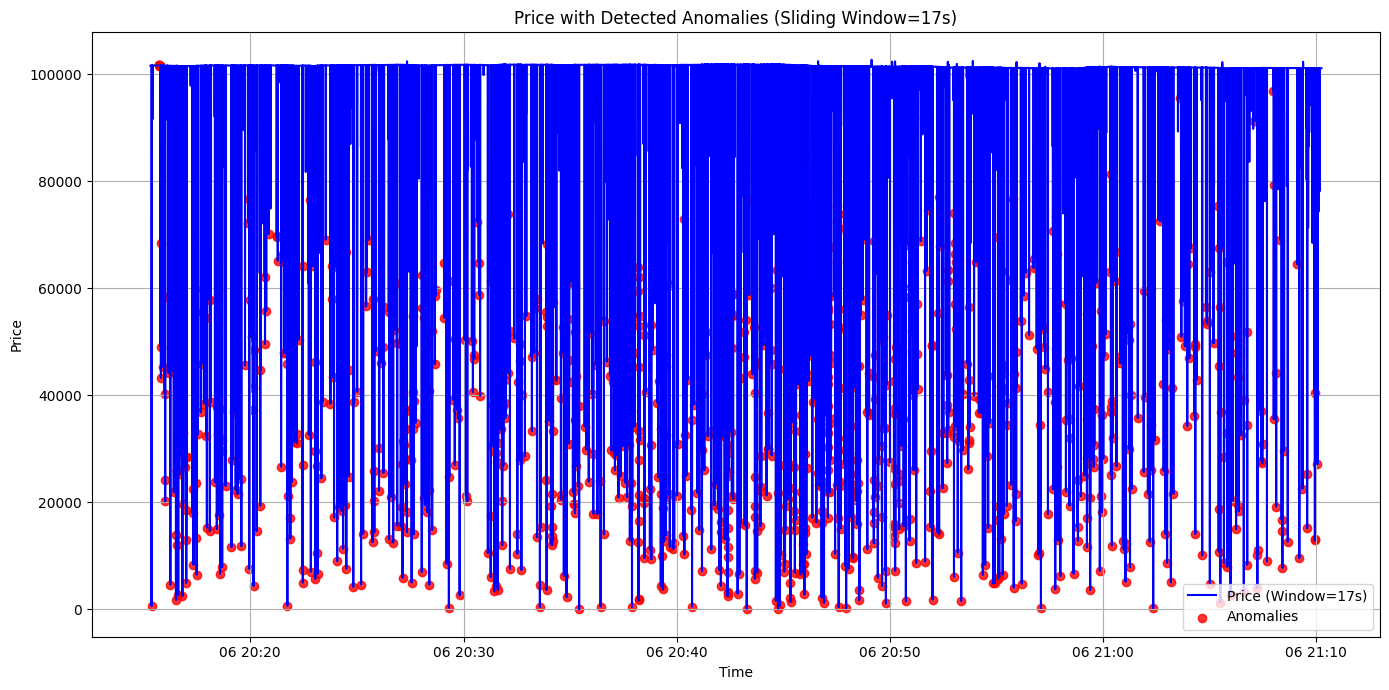

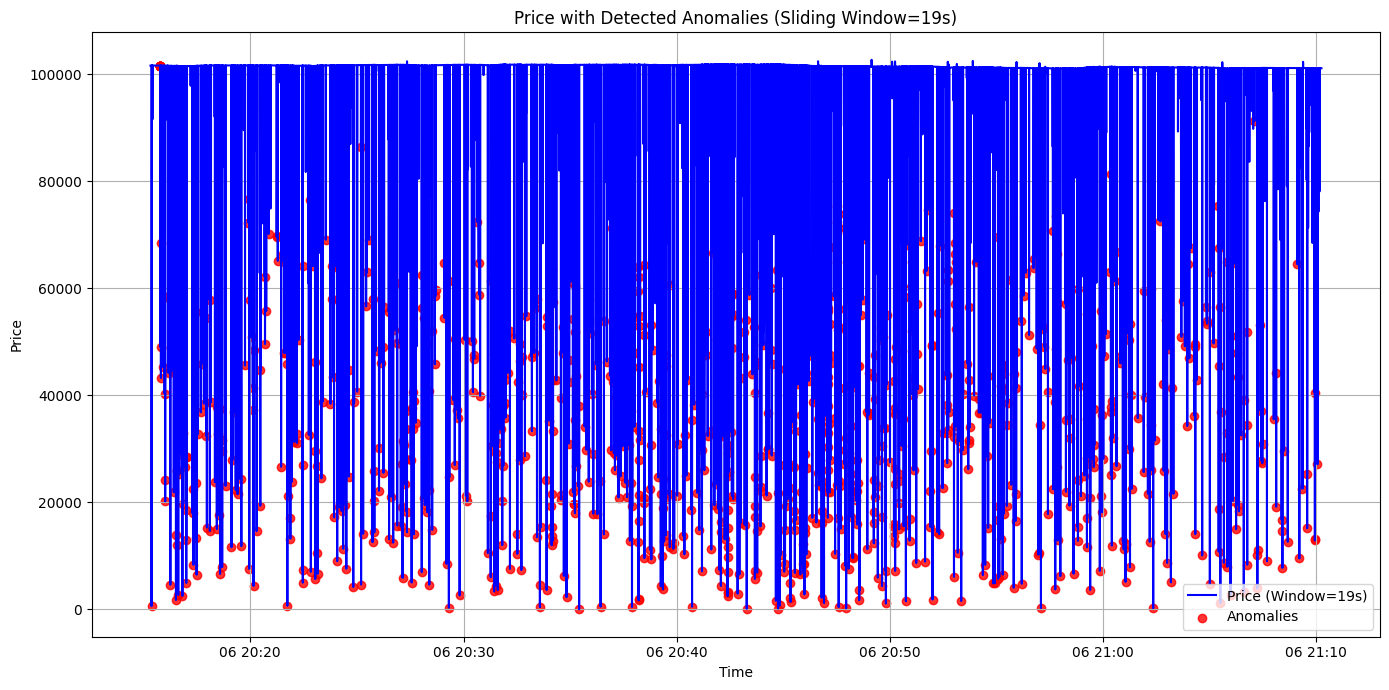

In [16]:
stats_table = []
def plot_anomalies_per_window_sliding(df, column, window_sizes_seconds, z_score_threshold):
    for window_size in window_sizes_seconds:
        # Detect anomalies using sliding window
        anomalies = detect_anomalies_sliding_window(df, column, window_size, z_score_threshold)
        anomaly_points = df[column][anomalies]  # Get anomaly values
        stat = f"Anomaly Count for {window_size}s: {len(anomaly_points)}; {int(len(anomaly_points) / len(df) * 100)}%"
        stats_table.append(stat)
        
        # Plot the original data with anomalies
        plt.figure(figsize=(14, 7))
        plt.plot(df.index, df[column], label=f'{column.capitalize()} (Window={window_size}s)', color='blue', linewidth=1.5)
        plt.scatter(anomaly_points.index, anomaly_points, label=f'Anomalies', color='red', alpha=0.8)
        
        # Add plot details
        plt.title(f"{column.capitalize()} with Detected Anomalies (Sliding Window={window_size}s)")
        plt.xlabel("Time")
        plt.ylabel(column.capitalize())
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Example usage: Create separate plots for each window size
plot_anomalies_per_window_sliding(df, "price", window_sizes, z_score_threshold)



In [17]:
vs = []
for t in stats_table:
    print(t)
    v = int(t.split(";")[1].strip().split("%")[0])
    vs.append(v)
print(f"The average percent of anomalies per different windows is {sum(vs)/len(vs):.2f}% of the total")


Anomaly Count for 1s: 1034; 2%
Anomaly Count for 3s: 1591; 3%
Anomaly Count for 5s: 1478; 3%
Anomaly Count for 7s: 1330; 3%
Anomaly Count for 11s: 1142; 2%
Anomaly Count for 13s: 1121; 2%
Anomaly Count for 17s: 1061; 2%
Anomaly Count for 19s: 1048; 2%
The average percent of anomalies per different windows is 2.38% of the total


# For finnhub 2h 6.12.2024
Anomaly Count for 4s: 3222; 5%
Anomaly Count for 8s: 3105; 5%
Anomaly Count for 12s: 2866; 4%
Anomaly Count for 16s: 2546; 4%
Anomaly Count for 20s: 2389; 4%
Anomaly Count for 24s: 2256; 3%
Anomaly Count for 28s: 2231; 3%
Anomaly Count for 32s: 2060; 3%
The average percent of anomalies per different windows is 3.88% of the total

# For finnhub 2h 7.12.2024
Anomaly Count for 4s: 2215; 5%
Anomaly Count for 8s: 2592; 6%
Anomaly Count for 12s: 2269; 5%
Anomaly Count for 16s: 2265; 5%
Anomaly Count for 20s: 2154; 5%
Anomaly Count for 24s: 2014; 4%
Anomaly Count for 28s: 1948; 4%
Anomaly Count for 32s: 1818; 4%
The average percent of anomalies per different windows is 4.75% of the total

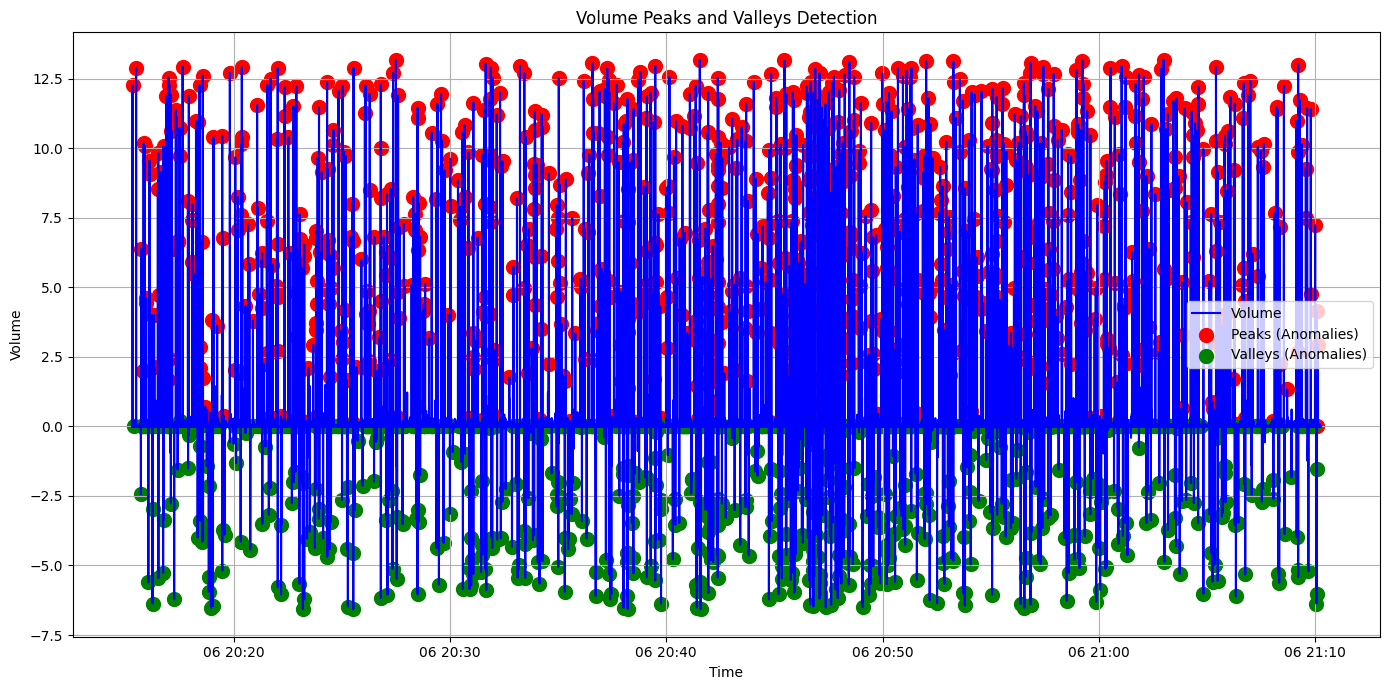

Peaks:
                                           price     volume  volume_smooth  \
trade_ts                                                                    
2024-12-06 20:15:19.930000+00:00  101664.000000  12.260216      12.260216   
2024-12-06 20:15:29.859000+00:00  101666.150000  12.892426      12.892426   
2024-12-06 20:15:44.261000+00:00  101668.680000   6.396042       6.396042   
2024-12-06 20:15:48.421000+00:00  101656.000000   1.999990       1.999990   
2024-12-06 20:15:50.631000+00:00  101640.010000  10.183155      10.183155   
...                                         ...        ...            ...   
2024-12-06 21:09:47.103000+00:00   89168.837302   4.750335       4.750335   
2024-12-06 21:09:59.270000+00:00  101149.150000   7.238201       7.238201   
2024-12-06 21:10:03.036000+00:00   27113.817863   0.006000       0.006000   
2024-12-06 21:10:03.453000+00:00  101120.000000   4.152648       4.152648   
2024-12-06 21:10:07.092000+00:00  101129.890000   2.937365       2.9

In [18]:
from scipy.signal import find_peaks


# Combined function to detect peaks and valleys
def detect_peaks_and_valleys(input_df, column, prominence_peaks=50, prominence_valleys=50):
    """
    Detect peaks and valleys in the volume data and mark them as anomalies.
    
    :param input_df: DataFrame containing the time-series data
    :param column: Column name containing the volume data
    :param prominence_peaks: Minimum prominence of a peak to be considered
    :param prominence_valleys: Minimum prominence of a valley to be considered
    :return: DataFrame with peak and valley anomaly columns
    """
    # Detect peaks
    peaks, _ = find_peaks(input_df[column], prominence=prominence_peaks)
    
    # Detect valleys (inverted peaks)
    inverted_volume = -input_df[column]
    valleys, _ = find_peaks(inverted_volume, prominence=prominence_valleys)
    
    # Add anomaly columns
    input_df['peak_anomaly'] = 0  # Default: not a peak anomaly
    input_df['valley_anomaly'] = 0  # Default: not a valley anomaly
    
    # Mark peaks and valleys using iloc for integer-based indexing
    input_df.iloc[peaks, input_df.columns.get_loc('peak_anomaly')] = 1
    input_df.iloc[valleys, input_df.columns.get_loc('valley_anomaly')] = 1
    return input_df

# Detect peaks and valleys
volume_df = detect_peaks_and_valleys(df, column='volume', prominence_peaks=1.5, prominence_valleys=1.5)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(volume_df.index, volume_df['volume'], label='Volume', color='blue', linewidth=1.5)
plt.scatter(volume_df.index[volume_df['peak_anomaly'] == 1], 
            volume_df['volume'][volume_df['peak_anomaly'] == 1], 
            label='Peaks (Anomalies)', color='red', s=100)
plt.scatter(volume_df.index[volume_df['valley_anomaly'] == 1], 
            volume_df['volume'][volume_df['valley_anomaly'] == 1], 
            label='Valleys (Anomalies)', color='green', s=100)
plt.title("Volume Peaks and Valleys Detection")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print detected peaks and valleys
print("Peaks:\n", volume_df[volume_df['peak_anomaly'] == 1])
print("Valleys:\n", volume_df[volume_df['valley_anomaly'] == 1])
